In [1]:
"""Key requirements: basemap, h5py"""
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py as h5
import os
os.environ['PROJ_LIB'] = "/global/homes/a/amahesh/.conda/envs/plotting_env/share/proj"
from mpl_toolkits.basemap import Basemap
import numpy as np
#import netCDF4 as nc
import h5py as h5
from matplotlib.colors import ListedColormap
import pandas as pd

In [10]:
""" This is Sean's plotting function """
def plot_mask_sean(img_array, storm_mask, plt_title, cbar_title, my_cmap=None, u_wind=None, v_wind=None):
  """
        img_array: This is the contour that is being plotted (i.e. TMQ)
        storm_mask: This creates a mask on top of the img_array contour showing the storm labels.  If you do not wish
                to see a predefined mask, you can input np.zeros(img_array.shape) for this field
        plt_title: The title of the plot
        my_cmap: input a custom colormap for the img_array contour.  The default colormap is good though
        u_wind: wind values in the u direction
        v_wind: wind values in the v direction
  """
  # Set alpha
  if my_cmap is None:
      # Choose colormap
      cmap = mpl.cm.viridis
      # Get the colormap colors
      my_cmap = cmap(np.arange(cmap.N))
      alpha = np.linspace(0, 1, cmap.N)
      my_cmap[:,0] = (1-alpha) + alpha * my_cmap[:,0]
      my_cmap[:,1] = (1-alpha) + alpha * my_cmap[:,1]
      my_cmap[:,2] = (1-alpha) + alpha * my_cmap[:,2]

      # Create new colormap
      my_cmap = ListedColormap(my_cmap)
  
  # l = p['label'] / 100
  p = storm_mask #p['prediction']
  p = np.roll(p,[0,1152//2])
  p1 = (p == 100)
  p2 = (p == 2)

  d = img_array #h['climate']['data'][0,...]
  d = np.roll(d,[0,1152//2])

  lats = np.linspace(-90,90,768)
  longs = np.linspace(-180,180,1152)

  def do_fig(figsize):
      fig = plt.figure(figsize=figsize)

      # my_map = Basemap(projection='eck4', lon_0=np.median(lons),
      #                  resolution = 'c')
      my_map = Basemap(projection='robin', llcrnrlat=min(lats), lon_0=np.median(longs),
                  llcrnrlon=min(longs), urcrnrlat=max(lats), urcrnrlon=max(longs), resolution = 'c')
      xx, yy = np.meshgrid(longs, lats)
      x_map,y_map = my_map(xx,yy)
      my_map.drawcoastlines(color=[0.5,0.5,0.5])
      
      if "threshold" in plt_title.lower():
            my_map.contourf(x_map,y_map,d,64,cmap=my_cmap)
            cbar = my_map.colorbar(ticks=[0,1])
            cbar.ax.set_ylabel(cbar_title)
      else:
          my_map.contourf(x_map,y_map,d,64,cmap=my_cmap)
          cbar = my_map.colorbar()
          cbar.ax.set_ylabel(cbar_title)
      if u_wind is not None and v_wind is not None:
          wind_speed = np.sqrt(u_wind**2 + v_wind**2)
          my_map.quiver(x_map[::20,::20],y_map[::20,::20], u_wind[::20,::20], v_wind[::20,::20], wind_speed[::20,::20], alpha=0.5)
      #my_map.contourf(x_map,y_map,d,64,cmap=my_cmap, vmax=89, vmin=0, levels=np.arange(0,89,2))
      
      plt.title(plt_title)
      if True:
          ar_contour = my_map.contour(x_map,y_map,p2,[0.5],linewidths=1,colors='blue', label='Atmospheric River')
          tc_contour = my_map.contour(x_map,y_map,p1,[0.5],linewidths=1,colors='red', label='Tropical Cyclone')
          
      my_map.drawmeridians(np.arange(-180, 180, 60), labels=[0,0,0,1])
      my_map.drawparallels(np.arange(-90, 90, 30), labels =[1,0,0,0])
      
      lines = []
      labels = []
      if np.sum(p1) > 0:
            lines.append(tc_contour.collections[0])
            labels.append("Tropical Cyclone")
      if np.sum(p2) > 0:
            lines.append(ar_contour.collections[0])
            labels.append("Atmospheric River")
      if np.sum(p1) > 0 or np.sum(p2) > 0:
          plt.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=len(lines))
      plt.show()
#       mask_ex = plt.gcf()
#       mask_ex.savefig("./" + plt_title.replace(" ", "")+".png",bbox_inches='tight')
#       plt.clf()
  
  do_fig((10,7))

In [11]:
""" Load in the TMQ, U850, and V850 from the data file"""
filepath = "/project/projectdirs/dasrepo/gb2018/tiramisu/segm_h5_v3_reformat/data-2107-09-24-06-4.h5"
data_in = h5.File(filepath)
TMQ = data_in['climate']['data'][0]
U850 = data_in['climate']['data'][1]
V850 = data_in['climate']['data'][2]
QREFHT = data_in['climate']['data'][5]

/global/homes/a/amahesh/.conda/envs/plotting_env/lib/python2.7/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/global/homes/a/amahesh/.conda/envs/plotting_env/lib/python2.7/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'label'
  s)


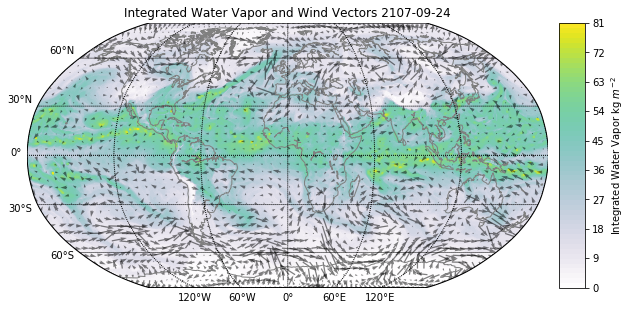

In [7]:
""" Plot TMQ, U850, and V850 from the data file"""
plot_mask_sean(TMQ, np.zeros(TMQ.shape), 
               "Integrated Water Vapor and Wind Vectors {}-{:02d}-{}".format(2107, 9, 24), 
               'Integrated Water Vapor kg $m^{-2}$', u_wind=U850, v_wind=V850)

In [4]:
U850.shape

(768, 1152)

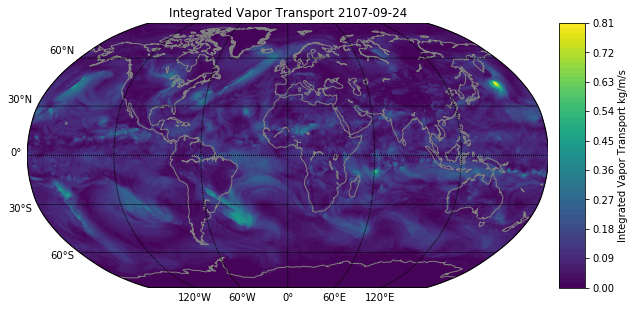

In [42]:
""" Calculate and plot the IVT approximation """
IVT_u = U850 * QREFHT
IVT_v = V850 * QREFHT
IVT = np.sqrt(IVT_u**2 + IVT_v**2)
plot_mask_sean(IVT, np.zeros(TMQ.shape), "Integrated Vapor Transport {}-{:02d}-{}".format(2107, 9, 24), 
               'Integrated Vapor Transport kg/m/s','viridis')

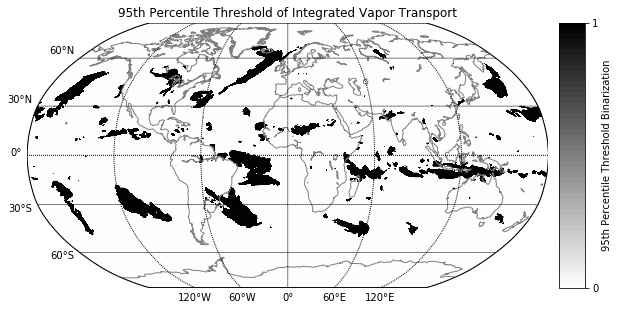

In [60]:
"""Threshold the IVT approximation and plot it"""
thresh = IVT > np.percentile(IVT, 95)
plot_mask_sean(thresh.astype('int'), np.zeros(TMQ.shape), "95th Percentile Threshold of Integrated Vapor Transport".format(2107, 9, 24),"95th Percentile Threshold Binarization", 'binary')

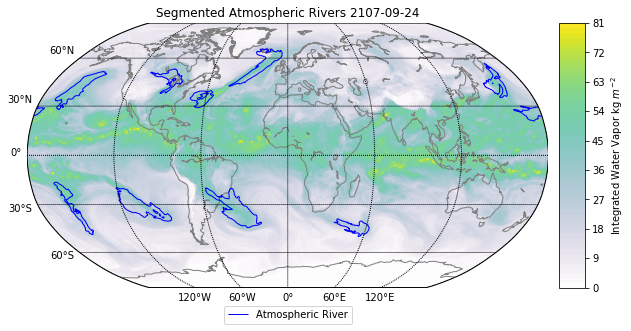

In [17]:
plot_mask_sean(TMQ, data_in['climate']['labels'][:], "Segmented Atmospheric Rivers {}-{:02d}-{}".format(2107, 9, 24), 
               'Integrated Water Vapor kg $m^{-2}$')